# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<b>Описание данных:</b>
- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
#для начала импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузим и сохраним датасеты
geo1=pd.read_csv('/datasets/geo_data_0.csv')
geo2=pd.read_csv('/datasets/geo_data_1.csv')
geo3=pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo1.sample(5)

,id,f0,f1,f2,product
66314,vwpkP,-1.101797,0.121504,1.482206,57.872273
55395,3nULw,-0.861821,0.258906,4.378768,101.887198
7872,cGjna,1.665297,-0.451329,7.328783,168.590683
88459,nMwtL,1.500548,-0.206621,9.495703,148.010514
13443,GiXNe,0.873081,-0.699405,6.156894,149.501962


Проверим все три датасета на пропуски, дубликаты, а также корелляцию данных внутри датасета.

#### Знакомство с первым датасетом

In [4]:
geo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
print('Количество пропусков в первом датасете:', geo1.duplicated().sum())

Количество пропусков в первом датасете: 0


<AxesSubplot:>

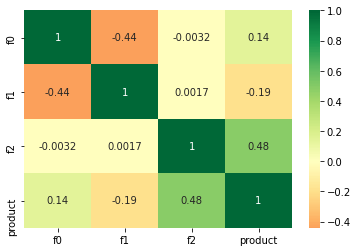

In [6]:
sns.heatmap(geo1.corr(), annot=True, cmap='RdYlGn', center=0)

По результатам изучения первого датасета можно сказать следующее:
- датасет содержит 100 000 строк и 5 столбцов;
- пропусков и дубликатов нет;
- корреляции между признаками f0, f1 и объемом запасов практически нет;
- есть средняя корреляция между признаком f2 и объемом запасов.

#### Знакомство со вторым датасетом

In [7]:
geo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
print('Количество пропусков во втором датасете:', geo2.duplicated().sum())

Количество пропусков во втором датасете: 0


<AxesSubplot:>

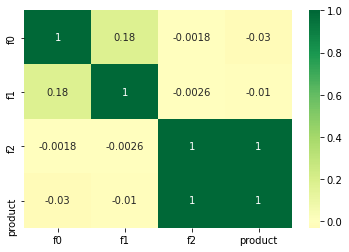

In [9]:
sns.heatmap(geo2.corr(), annot=True, cmap='RdYlGn', center=0)

По результатам изучения второго датасета можно сказать следующее:
- датасет содержит 100 000 строк и 5 столбцов;
- пропусков и дубликатов нет;
- корреляции между признаками f0, f1 и объемом запасов практически нет;
- корреляция между признаком f2 и объемом запасов равна единице, то есть между двумя этими признаками есть прямая взаимозависимость и связь.

#### Знакомство со третьим датасетом

In [10]:
geo3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
print('Количество пропусков в третьем датасете:', geo3.duplicated().sum())

Количество пропусков в третьем датасете: 0


<AxesSubplot:>

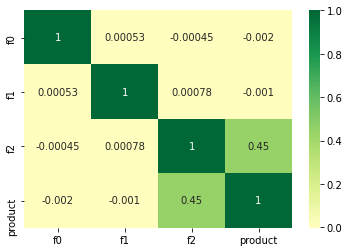

In [12]:
sns.heatmap(geo3.corr(), annot=True, cmap='RdYlGn', center=0)

По результатам изучения третьего датасета можно сказать следующее:
- датасет содержит 100 000 строк и 5 столбцов;
- пропусков и дубликатов нет;
- корреляции между признаками f0, f1 и объемом запасов практически нет;
- есть средняя корреляция между признаком f2 и объемом запасов в скважине .

#### Удаление столбцов

Удалим ненужный нам столбец `id` из всех датасетов, т.к. он не нужен для обучения модели.

In [13]:
geo1=geo1.drop(['id'], axis=1)
geo2=geo2.drop(['id'], axis=1)
geo3=geo3.drop(['id'], axis=1)
geo1.sample(5)

,f0,f1,f2,product
3133,-0.293830,1.016207,5.439318,93.853574
37058,0.559960,0.933408,1.763766,26.251373
11087,0.344323,0.801355,0.321195,28.439257
6820,0.636404,-0.684702,3.565889,181.413563
61431,-1.070765,0.367306,-1.628127,33.080863


### Вывод по разделу

1. Все 3 датасета уже подготовлены для машинного обучения, в них содержится 100 000 строк и 5 столбцов.
2. Во всех датасетах уже изначально было произведено масштабирование признаков.
3. Столбец `id` содержит тип данных `object`, все остальные столбцы - `float64`.
4. Пропусков и дубликатов в датасетах нет.
5. Корреляции во всех датасетах между признаками f0, f1 и объемом запасов в скважине практически нет.
6. В первом и третьем датасетах есть средняя корреляция между признаком f2 и объемом запасов в скважине, а во втором датасете корреляция между этими признаками равна 1.
7. Из всех датасетов удален столбец `id`, т.к. он не нужен для машинного обучения.

## Обучение и проверка модели

Обучим модель линейной регрессии в которой для каждого региона:
1. Разделим выборку на обучающую и валидационную.
2. Обучим модель.
3. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

In [14]:
#разделим выборку на обучающую и валидационную
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    geo1.drop(['product'], axis=1), geo1['product'], test_size=0.25, random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    geo2.drop(['product'], axis=1), geo2['product'], test_size=0.25, random_state=12345)

features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    geo3.drop(['product'], axis=1), geo3['product'], test_size=0.25, random_state=12345)

In [15]:
#для этого напишем функцию
def model_fit(features_train, features_valid, target_train, target_valid):
        
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)

    predictions_mean = predictions.mean()
    rmse = mean_squared_error(target_valid, predictions)**0.5

    print('Cредний предсказанный запас сырья: {:.2f}'.format(predictions_mean))
    print('RMSE модели: {:.2f}'.format(rmse))
    
    return predictions

In [16]:
#предсказание по первому датасету
predictions_1 = model_fit(features_train_1, features_valid_1, target_train_1, target_valid_1)

Cредний предсказанный запас сырья: 92.59
RMSE модели: 37.58


In [17]:
#предсказание по второму датасету
predictions_2 = model_fit(features_train_2, features_valid_2, target_train_2, target_valid_2)

Cредний предсказанный запас сырья: 68.73
RMSE модели: 0.89


In [18]:
#предсказание по третьему датасету
predictions_3 = model_fit(features_train_3, features_valid_3, target_train_3, target_valid_3)

Cредний предсказанный запас сырья: 94.97
RMSE модели: 40.03


### Вывод по разделу

1. Выборка была разбита на обучающую и валидационную.
2. Была написана функция для обучения модели по каждому датасету и сохранены результаты предсказаний для каждого датасета.
3. Предсказание по 1 и 3 датасету примерно одинаково и в них прогнозируется высокий уровень запаса сырья в скважинах, но при этом и RMSE данных моделей достаточно высок, поэтому точность предсказаний под вопросом.
4. Предсказание по 2 датасету говорит о меньшем количестве сырья в скважинах, но и RMSE данной модели ниже 1, что может говорить о точности предсказаний, либо переобучении модели, т.к. в данном датасете была высокая корреляция между признаками и целевым признаком.

## Подготовка к расчёту прибыли

Сохраним все используемые данные в отдельные переменные.

In [19]:
#переменная с точками для исследования
RESEARCH_POINTS = 500

#лучшие точки для разработки
BEST_POINTS = 200

#бюджет
BUDGET = 10000000000

#доход
INCOME = 450000

Рассчитаем доступный бюджет на каждую скважину, а также минимальное количество баррелей, необходимое для добычи из одной скважины, чтобы окупить затраты.

In [20]:
budget_per_point = BUDGET / BEST_POINTS
print('Бюджет на разработку одной точки:', budget_per_point)

Бюджет на разработку одной точки: 50000000.0


Бюджет на разработку одной точки составляет 50 млн. Посчитаем сколько нужно добывать бареллей из данной скважины, чтобы окупить затраты на ее бурение.

In [21]:
min_barrels = budget_per_point / INCOME
print('Минимальное количество баррелей для окупаемости:', min_barrels)

Минимальное количество баррелей для окупаемости: 111.11111111111111


Вспомним, какие объемы добычи предсказывает наша модель по трем регионам.

In [22]:
print('Средний запас сырья по первому региону: {:.2f} тыс. баррелей'.format(predictions_1.mean()))
print('Средний запас сырья по второму региону: {:.2f} тыс. баррелей'.format(predictions_2.mean()))
print('Средний запас сырья по третьему региону: {:.2f} тыс. баррелей'.format(predictions_3.mean()))

Средний запас сырья по первому региону: 92.59 тыс. баррелей
Средний запас сырья по второму региону: 68.73 тыс. баррелей
Средний запас сырья по третьему региону: 94.97 тыс. баррелей


### Вывод по разделу

Мы выяснили, что для окупаемости затрат на разработку из каждой скважины нужно добывать 111,11 тысяч баррелей и исходя из значений нашей модели предсказания, ни один из регионов не обеспечит необходимый запас сырья, т.к. максимальное значение указано в регионе 3 со средним показателем 94.97 тыс. баррелей.

Посмотрим на доход с лучших скважин.

## Расчёт прибыли и рисков 

### Расчет прибыли

Для начала создадим функцию, которая будет брать 200 точек с максимальным объемом добычи из наших датасетов по каждому региону и считать по ним суммарную прибыль.

In [23]:
#переведем наши предсказания в формат Series, чтобы их можно было отсортировать
predictions_1 = pd.Series(predictions_1, index=target_valid_1.index)
predictions_2 = pd.Series(predictions_2, index=target_valid_2.index)
predictions_3 = pd.Series(predictions_3, index=target_valid_3.index)

In [24]:
def profit(target, predictions):
    predictions_sorted=predictions.sort_values(ascending=False)
    volume = target[predictions_sorted.index][:200]
    return ((volume.sum() * INCOME - BUDGET))

In [25]:
print('Предполагаемая прибыль в первом регионе из 200 лучших скважин {:.2f} рублей'
      .format(profit(target_valid_1, predictions_1)))
print('Предполагаемая прибыль во втором регионе из 200 лучших скважин {:.2f} рублей'
      .format(profit(target_valid_2, predictions_2)))
print('Предполагаемая прибыль в третьем регионе из 200 лучших скважин {:.2f} рублей'
      .format(profit(target_valid_3, predictions_3)))

Предполагаемая прибыль в первом регионе из 200 лучших скважин 3320826043.14 рублей
Предполагаемая прибыль во втором регионе из 200 лучших скважин 2415086696.68 рублей
Предполагаемая прибыль в третьем регионе из 200 лучших скважин 2710349963.60 рублей


### Расчет рисков

На этом этапе:

1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [26]:
#сначала напишем функцию
def bootstrap(target_valid, predictions, geo):
    state = np.random.RandomState(12345)
    values = []
    target_valid = target_valid
    predictions = predictions
    for i in range(1000):
        target_subsample = target_valid.sample(RESEARCH_POINTS, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, predictions_subsample))
        
    values = pd.Series(values)
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = (values < 0).mean()*100
    
    print('Регион', geo)
    print('Средняя прибыль: {:,.2f}'.format(mean))
    print('Доверительный интервал, min: {:,.2f}'.format(lower))
    print('Доверительный интервал, max: {:,.2f}'.format(upper))
    print('Риск убытков: {} %'.format(risk))

In [27]:
bootstrap (target_valid_1, predictions_1, 1)

Регион 1
Средняя прибыль: 425,938,526.91
Доверительный интервал, min: -102,090,094.84
Доверительный интервал, max: 947,976,353.36
Риск убытков: 6.0 %


In [28]:
bootstrap (target_valid_2, predictions_2, 2)

Регион 2
Средняя прибыль: 515,222,773.44
Доверительный интервал, min: 68,873,225.37
Доверительный интервал, max: 931,547,591.26
Риск убытков: 1.0 %


In [29]:
bootstrap (target_valid_3, predictions_3, 3)

Регион 3
Средняя прибыль: 435,008,362.78
Доверительный интервал, min: -128,880,547.33
Доверительный интервал, max: 969,706,954.18
Риск убытков: 6.4 %


### Вывод по разделу

Исходя из расчетов средних показателей самым наименее рискованным и при этом прибыльным является второй регион. Плюс там 5% квантиль является положительным числом, поэтому чисто теоретически уйти в убытки в этом регионе не получится.

Но помня, что там есть высокая корреляция между признаками и целевым признаком, а RMSE составляет всего 0,89, этим данным я бы не доверял и рекомендовал для разработки первый регион, т.к. там самый высокий показатель прибыли из всех трех регионов, если добывать из 200 лучших скважин (3,32 млрд. рублей), плюс он является менее рискованным, чем третий регион.

## Вывод

1. Подготовка данных:
    1. Все 3 датасета уже были подготовлены для машинного обучения, в них содержится 100 000 строк и 5 столбцов. Во всех датасетах уже изначально было произведено масштабирование признаков. Пропусков и дубликатов в датасетах нет.
    2. Корреляции во всех датасетах между признаками f0, f1 и объемом запасов в скважине практически нет. В первом и третьем датасетах есть средняя корреляция между признаком f2 и объемом запасов в скважине, а во втором датасете корреляция между этими признаками равна 1.
    3. Из всех датасетов удален столбец id, т.к. он не нужен для машинного обучения.
2. Обучение модели:
    1. Для обучения выборка была разбита на обучающую и валидационную.
    2. Была написана функция для обучения модели по каждому датасету и сохранены результаты предсказаний для каждого датасета.
    3. Предсказание по 1 и 3 датасету примерно одинаково и в них прогнозируется высокий уровень запаса сырья в скважинах, но при этом и RMSE данных моделей достаточно высок, поэтому точность предсказаний под вопросом.
    4. Предсказание по 2 датасету говорит о меньшем количестве сырья в скважинах, но и RMSE данной модели ниже 1, что может говорить о точности предсказаний, но скорее говорит о переобучении модели, т.к. в данном датасете была высокая корреляция между признаками и целевым признаком.
3. Мы выяснили, что для окупаемости затрат на разработку из каждой скважины нужно добывать 111,11 тысяч баррелей и исходя из значений нашей модели предсказания, ни один из регионов не обеспечит необходимый запас сырья, т.к. максимальное значение указано в регионе 3 со средним показателем 94.97 тыс. баррелей.
4. Исходя из расчетов средних показателей самым наименее рискованным и при этом прибыльным является второй регион. Плюс там 5% квантиль является положительным числом, поэтому чисто теоретически уйти в убытки в этом регионе не получится.
Но помня, что там есть высокая корреляция между признаками и целевым признаком, а RMSE составляет всего 0,89, этим данным я бы не доверял и рекомендовал для разработки первый регион, т.к. там самый высокий показатель прибыли из всех трех регионов, если добывать из 200 лучших скважин (3,32 млрд. рублей), плюс он является менее рискованным, чем третий регион.